# Your first deep neural network

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Flatten, Dense, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.datasets import cifar10

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

2022-12-22 22:56:32.498447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
torch.__version__

'1.13.0'

# data

In [3]:
NUM_CLASSES = 10

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train_index = np.array(y_train)
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [6]:
x_train[54, 12, 13, 1] 

0.36862746

# architecture

In [7]:
input_layer = Input((32,32,3))

x = Flatten()(input_layer)

x = Dense(200, activation = 'relu')(x)
x = Dense(150, activation = 'relu')(x)

output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

2022-12-22 22:56:42.227476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 150)               30150     
                                                                 
 dense_2 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


### Pytorch Model Replica

In [9]:
class PytorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(3072, 200)
        self.dense2 = nn.Linear(200, 150)
        self.dense3 = nn.Linear(150, 10)
        self._initialize_weights()
        
    def forward(self, x):
        out = self.flatten(x)
        out = self.dense1(out)
        out = nn.functional.relu(out)
        out = self.dense2(out)
        out = nn.functional.relu(out)
        out = self.dense3(out)
        out = nn.functional.softmax(out, dim=0)
        return out
    
    def _initialize_weights(self):
        with torch.no_grad():
            self.apply(self.init_weights)
                
    @staticmethod
    def init_weights(layer):
        if hasattr(layer, "weight"):
            torch.nn.init.xavier_uniform_(layer.weight)
            
        if hasattr(layer, "bias"):
            layer.bias.data.fill_(0.0)
            
    def fit(self, X, y, learning_rate=0.0005, batch_size=32, epochs=10, shuffle=True):
        optimizer = torch.optim.Adam(lr=learning_rate, params=self.parameters())
        dataset = TensorDataset(X, y)
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
        )

        loss_fn = nn.NLLLoss(reduction="sum")
        for epoch in range(1, epochs + 1):
            n, total_loss = 0, 0.0
            for obs, labels in train_loader:
                outputs = self(obs)
                loss = loss_fn(torch.log(outputs), labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                n += outputs.shape[0]
                total_loss += float(loss.item())
                
            avg_loss = 1.0 * total_loss / n
            print(f"Epoch {epoch} Loss: {avg_loss:.6f}")
        
        return self

In [10]:
pytorch_model = PytorchModel()
pytorch_model.fit(
    torch.from_numpy(x_train).type(torch.float32), 
    torch.from_numpy(y_train_index).squeeze(-1).type(torch.LongTensor),
)

Epoch 1 Loss: 2.994392
Epoch 2 Loss: 2.834868
Epoch 3 Loss: 2.768627
Epoch 4 Loss: 2.722635
Epoch 5 Loss: 2.689395
Epoch 6 Loss: 2.658607
Epoch 7 Loss: 2.638469
Epoch 8 Loss: 2.622241
Epoch 9 Loss: 2.600984
Epoch 10 Loss: 2.590307


PytorchModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=3072, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=150, bias=True)
  (dense3): Linear(in_features=150, out_features=10, bias=True)
)

In [11]:
pytorch_model(torch.from_numpy(x_train))[:10]

tensor([[9.6361e-07, 2.4837e-07, 1.8701e-05, 1.6893e-05, 8.3898e-06, 8.9093e-06,
         6.0323e-05, 6.5746e-06, 8.5810e-09, 7.6460e-08],
        [2.6937e-06, 9.4269e-05, 7.7977e-06, 5.7037e-06, 2.4019e-06, 4.3994e-06,
         8.8551e-07, 9.4649e-06, 1.7081e-05, 3.3671e-05],
        [2.9334e-06, 4.9534e-06, 6.4458e-07, 2.8268e-06, 2.8210e-06, 1.9564e-07,
         3.1567e-08, 1.7193e-05, 1.1762e-05, 3.2164e-04],
        [1.5439e-06, 2.4182e-07, 2.3143e-05, 2.0826e-05, 4.5875e-05, 2.0167e-05,
         1.0262e-04, 2.4163e-06, 3.8894e-07, 4.1803e-07],
        [3.0325e-05, 9.7526e-05, 3.6022e-07, 3.0771e-08, 1.8219e-06, 4.3519e-08,
         9.5562e-09, 9.3226e-07, 2.7571e-05, 4.6970e-05],
        [3.2206e-06, 4.0694e-05, 6.8688e-07, 5.0633e-06, 1.0780e-06, 4.6587e-06,
         6.1710e-06, 3.0659e-05, 5.2299e-07, 2.9903e-05],
        [1.4819e-05, 1.9196e-07, 5.4843e-05, 9.7909e-07, 2.4881e-05, 2.4320e-06,
         4.1390e-05, 5.9434e-07, 4.4651e-08, 9.3970e-08],
        [2.4766e-07, 2.6916

# train

In [12]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/Users/benjamincross/miniconda3/envs/GDL/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.8549 - accuracy: 0.3286
Epoch 2/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.6686 - accuracy: 0.4037
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5927 - accuracy: 0.4314
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5425 - accuracy: 0.4505
Epoch 5/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.5047 - accuracy: 0.4612
Epoch 6/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.4734 - accuracy: 0.4733
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4482 - accuracy: 0.4817
Epoch 8/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4227 - accuracy: 0.4928
Epoch 9/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4063 - accuracy: 0.4975
Epoch 10/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.39

# analysis

In [14]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4450 - accuracy: 0.4854


[1.4450435638427734, 0.48539999127388]

In [15]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

313/313 [==============================] - 1s 3ms/step


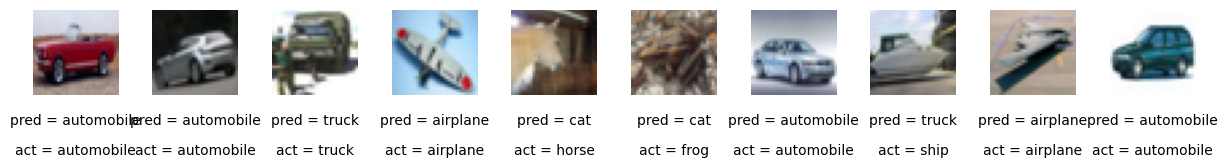

In [16]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

### Pytorch Analysis

In [17]:
preds = pytorch_model(torch.from_numpy(x_test))
pred_classes = CLASSES[torch.argmax(preds, axis=-1)]

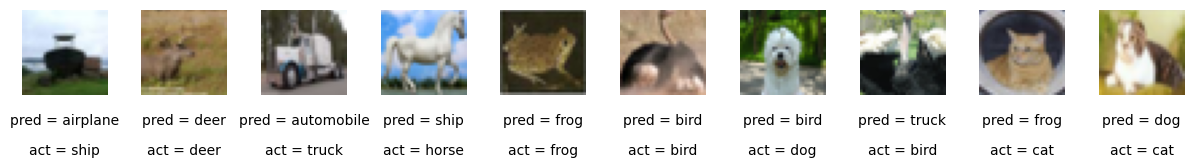

In [18]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(pred_classes[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

In [19]:
print("Accuracy: {:.4f}".format((pred_classes == actual_single).mean()))

Accuracy: 0.4936
